# LDA Assignment

LDA is a probabilistic topic model. The joint distribution is given by:
$$p(W, Z, \Theta, \Phi | \alpha, \eta) = \prod_{d=1}^D \Big( p(\theta_d | \alpha) \prod_{n=1}^{N_d} p(w_{d,n} | z_{d,n}, \Phi) p(z_{d,n} | \theta_d) \Big) \prod_{t=1}^T p(\phi_t | \eta) $$

Where:
$$p(\theta_d | \alpha) = Dir(\theta_d | \alpha)$$

$$p(w_{d,n} | z_{d,n}, \Phi) = Mult(W_{d,n} | \phi_{z_{d,n}})$$

$$p(z_{d,n} | \theta_d) = Mult(z_{d,n} | \theta_d)$$

$$p(\phi_t | \eta) = Dir(\phi_t | \eta)$$

In this assignment, you will apply Latent Dirichlet Allocation topic model to the dataset of NIPS papers. You will need `gensim` Python library which can be installed via `pip`.

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot
%matplotlib inline

import gensim

import logging

gensim.models.ldamodel.logger.setLevel(logging.ERROR)

Download the dataset prepared by Sam Roweis and put it into the folder with the IPython Notebook: http://www.cs.nyu.edu/~roweis/data/nips12raw_str602.mat

The following code performs the necessary preprocessing.

In [2]:
nips12 = scipy.io.loadmat('nips12raw_str602.mat', squeeze_me=True)

# num documents x num words matrix
counts = nips12['counts'].T

# leave only 2013 (~2k) most frequent words
words_mask = np.ravel(counts.sum(axis=0) >= 121)
counts = counts[:, words_mask]

# id -> word mapping (required by gensim)
nips12_id2word = {i: w for (i, w) in enumerate(nips12['wl'][words_mask])}

# word -> id mapping (required by pyLDAvis)
nips12_word2id = {w: i for (i, w) in enumerate(nips12['wl'][words_mask])}

# NIPS issue for each document. Issue 0 is NIPS proceeding of the year 1988, issue 1 is year 1989, etc.
nips12_issue = np.array([int(name[4:6]) for name in nips12['docnames']])

# Titles of papers
nips12_titles = nips12['ptitles']

# Full corpus in gensim format
full_corpus = gensim.matutils.Scipy2Corpus(counts)

stream = np.random.RandomState(seed=123)
subset_mask = stream.rand(counts.shape[0]) <= 0.1

# Small corpus of 10% random papers for quick experiments
small_corpus = gensim.matutils.Scipy2Corpus(counts[subset_mask, :])

Gensim uses iterative approach to LDA inference. First, variational inference is run for `iterations` number of iterations to produce the new values of the variational parameters. Then, the new values are "blended" with the old ones (the values from the previuos iteration of the EM-algorithm) by taking a weighted average. This is done `num_passes` times. This procedure allows to better escape the local optima for the variational parameters.

Use the following code template to run LDA model in Gensim. Additionally, you will get the value of the variational lower bound after every pass. For now, we use small corpus to make computations faster.

Note: the lower bound is related to the perplexity measure commonly used in natural language procesing: $perplexity = exp(-bound)$

In [4]:
num_topics = 10  # number of topics in LDA model
alpha = [0.1] * num_topics  # parameter of the Dirichlet prior for document/topic distribution
iterations = 50  # number of Variational Inference passes
num_passes = 10  # number of passes over the dataset

small_lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=alpha, iterations=iterations, id2word=nips12_id2word, eval_every=None)
for iter in range(num_passes):
    small_lda.update(small_corpus)
    print(small_lda.bound(small_corpus))

-832496.363527
-810101.19374
-804466.883119
-802294.720209
-801221.267575
-800659.18091
-800381.197642
-800278.300026
-800284.403387
-800353.402547


Tune the number of `iterations` and `num_passes`. Try to maximize the variational lower bound.

In [8]:
iterations = 50  # number of Variational Inference passes
num_passes = 20  # number of passes over the dataset

In [9]:
small_lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=alpha, iterations=iterations, id2word=nips12_id2word, eval_every=None)
for iter in range(num_passes):
    small_lda.update(small_corpus)
    print(small_lda.bound(small_corpus))

-830732.462112
-808911.217906
-802507.407526
-800266.269217
-799369.366717
-799025.335079
-798934.52471
-798968.419601
-799073.904942
-799210.618233
-799386.05916
-799576.782818
-799775.392618
-799983.272207
-800184.167935
-800378.465726
-800571.771835
-800758.79342
-800938.834509
-801115.530117


In [10]:
iterations = 100  # number of Variational Inference passes
num_passes = 10  # number of passes over the dataset

In [11]:
small_lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=alpha, iterations=iterations, id2word=nips12_id2word, eval_every=None)
for iter in range(num_passes):
    small_lda.update(small_corpus)
    print(small_lda.bound(small_corpus))

-820999.12059
-805028.773707
-800852.346892
-799397.24694
-798881.737454
-798748.047355
-798771.065393
-798883.553631
-799053.536667
-799241.254787


In [14]:
iterations = 30  # number of Variational Inference passes
num_passes = 8  # number of passes over the dataset

In [15]:
small_lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=alpha, iterations=iterations, id2word=nips12_id2word, eval_every=None)

for iter in range(num_passes):
    small_lda.update(small_corpus)
    print(small_lda.bound(small_corpus))

-842063.851889
-817262.966634
-806982.458814
-802939.280946
-801083.974096
-800098.713864
-799570.38797
-799287.187223


Study the sensitivity of the lower bound value to the prior parameter $\alpha$. Use symmetric values of $\alpha$.

In [27]:
iterations = 50  # number of Variational Inference passes
num_passes = 10  # number of passes over the dataset

A = np.arange(0.1, 1.1, 0.1)

for alpha in A:
    small_lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=[alpha] * num_topics, iterations=iterations, id2word=nips12_id2word, eval_every=None)
    
    for iter in range(num_passes):
        small_lda.update(small_corpus)
        
    print(alpha, small_lda.bound(small_corpus))

0.1 -799700.115709
0.2 -801725.830497
0.3 -800558.073944
0.4 -801309.519485
0.5 -804910.863599
0.6 -803414.640386
0.7 -803327.911125
0.8 -801992.786623
0.9 -805383.617378
1.0 -804145.228765


Fit the best model to the whole corpus.

In [5]:
iterations = 50  # number of Variational Inference passes
num_passes = 10  # number of passes over the dataset

alpha = 0.1

lda = gensim.models.LdaModel(passes=1, num_topics=num_topics, alpha=[alpha] * num_topics, iterations=iterations, id2word=nips12_id2word, eval_every=None)

for iter in range(num_passes):
    lda.update(full_corpus)

    print(lda.bound(full_corpus))

-7580889.63932
-7473488.95395
-7422962.20885
-7396119.66293
-7378939.16967
-7366595.2173
-7357152.50531
-7349398.71347
-7342789.14466
-7336986.81249


Extract the variational parameters $\gamma$ - parameters of the variational approximation to the posterior probability of a topic for a document: $q(\Theta_d) = Dir(\Theta_d | \gamma_d)$.

Normalize them to a get a probability distribution over the topics for each document (the mean probability distribution according to the Dirichlet distribution).

In [6]:
gamma, _ = lda.inference(full_corpus)
# Normalize gammas here.

s = gamma.sum(axis = 1)

for i in range(num_topics):
    gamma[:, i] /= gamma.sum(axis=1)

Visualize the approximate posterior distributions of probability of topics for some documents. Do this for documents from different years. Does the sparsity of the topics change over time? If so, can you explain this?

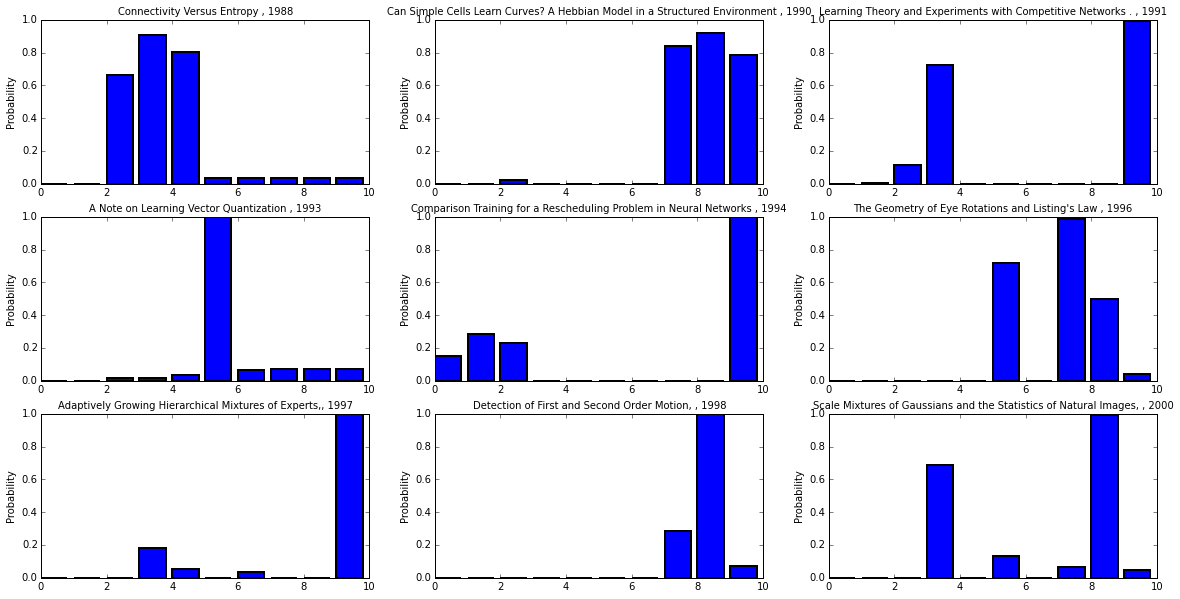

In [41]:
import matplotlib.pyplot as plt

%matplotlib inline 

num_topics = 10
documents = [[0, 200, 400], [600, 800, 1000], [1200, 1400, 1710]]

fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i in range(len(documents)):
    for j in range(len(documents[i])):
        d = documents[i][j]
        axes[i][j].bar(range(num_topics), gamma[d], lw=2)
        axes[i][j].set_title('%s, %d' % (nips12_titles[d], 1988 + nips12_issue[d]), fontsize=10)
        axes[i][j].set_ylabel("Probability")

Aticles becomes more concetrate on specifical topic and thus they become more sprarse.

Write the code to print the most probable words and most probable documents for each topic. You may need to use `lda.num_topics`, `lda.show_topic(topic, topn=10)` and normalized gammas computed in the previous task.

Analyze the results. Can you interpret the topics? Write your interpretation to at least 3 topics.

Note. If you find an interesting paper in the list, you can download it online, as NIPS proceedings are freely available!

In [45]:
for topic in range(lda.num_topics):
    print('Topic {0} \n Document: {1} \n Word: {2}'.format(topic,
                                                       nips12_titles[gamma[:, topic].argmax()],
                                                       lda.show_topic(topic)[0][0])
          )

Topic 0 
 Document: Exploiting Syllable Structure in a Connectionist Phonology Model ..  
 Word: network
Topic 1 
 Document: AN INTEGRATED ARCHITECTURE OF ADAPTIVE NEURAL NETWORK CONTROL FOR DYNAMIC SYSTEMS  
 Word: control
Topic 2 
 Document: Computing with Almost Optimal Size Neural Networks  
 Word: function
Topic 3 
 Document: Robust Parameter Estimation and Model Selection for Neural Network Regression 
 Word: data
Topic 4 
 Document: Spoken Letter Recognition .  
 Word: recognition
Topic 5 
 Document: Efficient Pattern Recognition Using a New Transformation Distance 
 Word: data
Topic 6 
 Document: Reinforcement Learning with Hierarchies of Machines,  
 Word: state
Topic 7 
 Document: OCULAR DOMINANCE AND PATTERNED LATERAL CONNFL-TIONS IN A SELF-ORGANIZING MODEL OFTHE PRIMARY VISUAL CORTEX  
 Word: model
Topic 8 
 Document: Improved Silicon Cochlea Using Compatible Lateral Bipolar Transistors  
 Word: figure
Topic 9 
 Document: Practical Characteristics of Neural Network and Conv

Topic 8: Electronics

Topic 3: Neural Networks

Topic 9: Neural Networks

Write the code to calculate the mean probability of a topic in a given year. Analyze which topics become more popular over the years, and which less popular.

In [7]:
num_docs = np.zeros(nips12_issue.max() + 1)
topics_per_year = np.zeros((nips12_issue.max() + 1, lda.num_topics))

for d in range(gamma.shape[0]):
    num_docs[nips12_issue[d]] += 1
    topics_per_year[nips12_issue[d]] += gamma[d]

for y in range(nips12_issue.max() + 1):
    topics_per_year[y] /= num_docs[y]

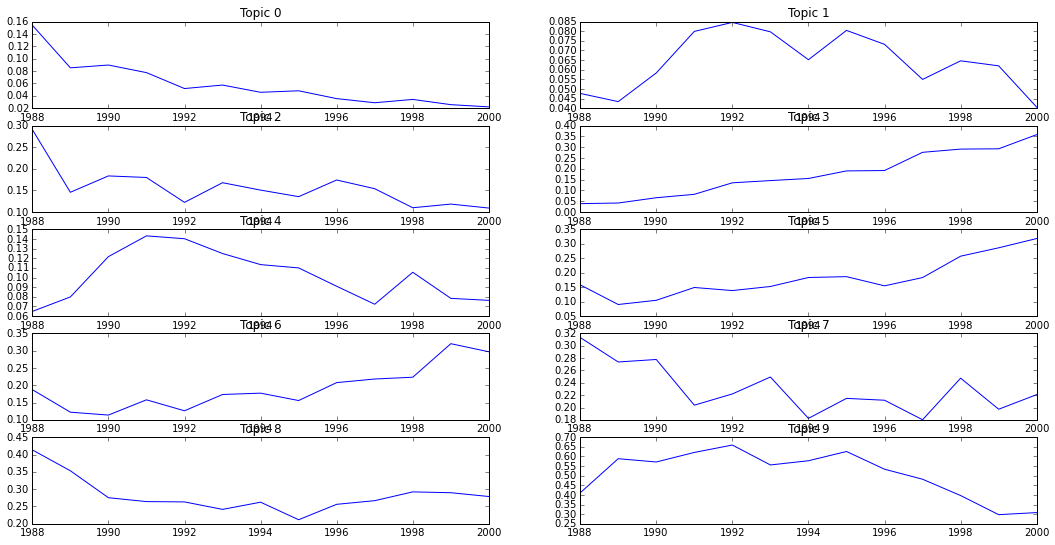

In [69]:
fig, axes = plt.subplots(5, 2, figsize=(18, 9))

for i in range(5):
    for j in range(2):
        axes[i][j].plot(np.array(list(set(nips12_issue))) + 1988, topics_per_year[:, 2 * i + j])
        axes[i][j].set_title('Topic %d' % (2 * i + j))

Use the following code to print topics found by LSI (Latent Semantic Indexing) model, a non-probabilistic topic model. What can you say about the interpretability of the topics? What about the running time?

In [8]:
lsi = gensim.models.LsiModel(full_corpus, num_topics=num_topics, id2word=nips12_id2word)
lsi.print_topics(10, num_words=20)

[(0,
  u'0.392*"network" + 0.276*"model" + 0.269*"neural" + 0.244*"input" + 0.221*"data" + 0.216*"training" + 0.206*"time" + 0.203*"set" + 0.199*"function" + 0.195*"figure" + 0.131*"state" + 0.118*"results" + 0.112*"hidden" + 0.100*"weights" + 0.099*"layer" + 0.089*"space" + 0.083*"case" + 0.080*"shown" + 0.080*"parameters" + 0.080*"order"'),
 (1,
  u'0.592*"network" + -0.553*"model" + -0.303*"data" + 0.178*"neural" + 0.153*"input" + 0.111*"layer" + 0.109*"training" + 0.098*"hidden" + -0.096*"distribution" + -0.092*"state" + 0.090*"weights" + -0.089*"parameters" + -0.073*"probability" + -0.070*"space" + 0.067*"net" + -0.065*"function" + -0.057*"density" + -0.056*"figure" + -0.054*"bayesian" + -0.050*"variables"'),
 (2,
  u'-0.402*"data" + -0.388*"training" + 0.297*"time" + 0.295*"model" + -0.292*"set" + 0.236*"state" + 0.162*"control" + 0.132*"input" + 0.126*"cell" + -0.116*"class" + 0.115*"figure" + -0.115*"test" + -0.107*"classification" + 0.098*"synaptic" + 0.088*"network" + 0.083*"

# Visualization

Run the following code to visialize the topics of your best model.

**Find two most simular topics.**

In [74]:
class MyDictionary():
    def __init__(self, word2id):
        self.token2id = word2id
    
    def __len__(self):
        return len(self.token2id)

    
class MyScipy2Corpus(gensim.matutils.Scipy2Corpus):
    def __len__(self):
        return self.vecs.shape[0]

In [75]:
lda.save('model.dat')

You will need to install `pyLDAvis` library e.g. via `pip`.

In [81]:
import pyLDAvis.gensim

lda = gensim.models.LdaModel.load('model.dat')
my_full_corpus = MyScipy2Corpus(counts[subset_mask, :])
my_dictionary = MyDictionary(nips12_word2id)
data = pyLDAvis.gensim.prepare(lda, my_full_corpus, my_dictionary)
pyLDAvis.display(data)

/usr/local/lib/python3.5/site-packages/pandas/__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib
/usr/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/usr/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use